# 2주차 심화세미나 추천시스템 실습 코드

- movies
 - ratings.csv
 - movies_metadata.csv

 데이터 출처: https://www.kaggle.com/chocozzz/t-academy-recommendation2

# Rule-based Model


## Apriori

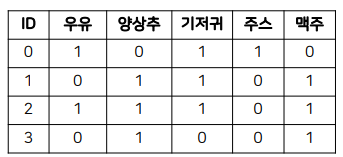

고객의 장바구니를 분석하여 나와 비슷한 영화를 본 유저의 정보를 바탕으로 영화를 추천

input = user가 지금 까지 본 영화

output = user가 본 영화 데이터를 기반으로 비슷한 영화를 묶어 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
meta = meta.rename(columns={'id':'movieId'})
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], how='left', on='movieId')
movie = movie[movie['original_title'].notnull()].reset_index(drop=True)
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,1,1405,1.0,1260759203,Greed
2,1,2105,4.0,1260759139,American Pie
3,1,2193,2.0,1260759198,My Tutor
4,1,2294,2.0,1260759108,Jay and Silent Bob Strike Back


In [ ]:
agg = movie.groupby(['userId'])['original_title'].agg({'unique'})
agg.head()

,unique
userId,
1,"[Rocky III, Greed, American Pie, My Tutor, Jay..."
2,"[The Dark, 2001: A Space Odyssey, Trois couleu..."
3,"[Trois couleurs : Rouge, The Killing, Carne tr..."
4,"[Italiensk for begyndere, Donnie Darko, Lost i..."
5,"[Varjoja paratiisissa, Lola rennt, Donnie Dark..."


In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(agg['unique'].values).transform(agg['unique'].values)

In [ ]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df.head()

,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...Più forte ragazzi!,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 + 1,12 Angry Men,13 Tzameti,1408,15 Minutes,16 Blocks,1724 기방난동사건,1942: A Love Story,1984,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,2046,2061 - Un anno eccezionale,21 Grams,24 Hour Party People,25th Hour,28 Days Later,28 Weeks Later,29th Street,2:37,3 Ninjas: High Noon at Mega Mountain,3 hommes et un couffin,300,33 sceny z życia,36 Fillette,"4 luni, 3 săptămîni și 2 zile",40 Days and 40 Nights,42nd Street,48 Hrs.,...,真夜中の弥次さん喜多さん,続宮本武蔵 一乗寺の決闘,綠草地,纵横四海,羅生門,英雄,菊次郎の夏,薔薇の葬列,蜘蛛巣城,裸の島,誰も知らない,豚と軍艦,赤ひげ,野火,鎗王之王,隠し砦の三悪人,風の谷のナウシカ,香港製造,鬼婆,鷹爪鐵布衫,거룩한 계보,고지전,공동경비구역 JSA,괴물,김복남 살인사건의 전말,다세포 소녀,도쿄!,밀양,봄 여름 가을 겨울 그리고 봄,빈집,사마리아,야수,연가시,오직 그대만,올드보이,"장화, 홍련",최종병기 활,친절한 금자씨,해안선,활
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)
association_rules(frequent_itemsets , metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Terminator 3: Rise of the Machines),(The Million Dollar Hotel),0.482861,0.463487,0.326379,0.675926,1.458348,0.102578,1.655525
1,(The Million Dollar Hotel),(Terminator 3: Rise of the Machines),0.463487,0.482861,0.326379,0.704180,1.458348,0.102578,1.748153
2,(Terminator 3: Rise of the Machines),(Солярис),0.482861,0.453055,0.333830,0.691358,1.525991,0.115067,1.772101
3,(Солярис),(Terminator 3: Rise of the Machines),0.453055,0.482861,0.333830,0.736842,1.525991,0.115067,1.965127
4,(Солярис),(The Million Dollar Hotel),0.453055,0.463487,0.308495,0.680921,1.469125,0.098509,1.681442
5,(The Million Dollar Hotel),(Солярис),0.463487,0.453055,0.308495,0.665595,1.469125,0.098509,1.635575


# Content-based Model

## one-hot-vector

유사한 장르의 영화를 추천

input = 행 - 영화, 열 - 영화의 장르, 값 - 원핫벡터

output = 각 영화별 유사한 장르의 영화를 추천 (여러가지 유사도를 이용하여 구함)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta[meta['overview'].notnull()].reset_index(drop=True)
meta = meta.iloc[:10000, :] # 메모리 문제로 10000 개만 실행

In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
def get_genres(x):
  result = []
  x = eval(x)
  for i in x:
    result.append(i['name'])
  return result

meta['clean_genres'] = meta['genres'].apply(get_genres)

In [ ]:
id2title = {}
title2id =  {}

for id, tilte in enumerate(meta['title']):
  id2title[id] = tilte
  title2id[tilte] = id

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(meta['clean_genres'].values).transform(meta['clean_genres'].values)

In [ ]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df.iloc[:, :] = df.values.astype(int)
df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def get_sim_tilte(sim_scores, idx, top = 10):
  sim_scores = [(i, c) for i, c in enumerate(sim_scores[idx]) if i != idx] # 자기 자신을 제외한 영화들의 유사도 및 인덱스를 추출 
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
  sim_scores = [(id2title[i], score) for i, score in sim_scores[0:top]]
  return sim_scores

In [ ]:
idx = title2id['Spider-Man 2']

In [ ]:
# 내적
dot_scores = np.dot(df.values, df.values.T)
get_sim_tilte(dot_scores, idx)

[('Mighty Morphin Power Rangers: The Movie', 3),
 ('Last Action Hero', 3),
 ('The Shadow', 3),
 ('Highlander', 3),
 ('Turbo: A Power Rangers Movie', 3),
 ('The Fifth Element', 3),
 ('Conan the Barbarian', 3),
 ('Spawn', 3),
 ('Kull the Conqueror', 3),
 ('The Borrowers', 3)]

In [ ]:
# 피어슨 유사도
pearson_scores = df.T.corr().values
get_sim_tilte(pearson_scores, idx)

[('Conan the Destroyer', 1.0),
 ('The Scorpion King', 1.0),
 ('Reign of Fire', 1.0),
 ('Sword of the Valiant: The Legend of Sir Gawain and the Green Knight', 1.0),
 ('Hawk the Slayer', 0.8401680504168053),
 ('Mothra vs. Godzilla', 0.8401680504168053),
 ('Pokémon Heroes: Latios and Latias', 0.8401680504168053),
 ('Mortal Kombat', 0.7934920476158719),
 ('Cutthroat Island', 0.7934920476158717),
 ('Shogun Assassin', 0.7934920476158717)]

In [ ]:
# 코사인 유사도
from sklearn.metrics.pairwise import cosine_similarity
cosine_scores = cosine_similarity(df, df)
get_sim_tilte(cosine_scores, idx)

[('Highlander', 1.0000000000000002),
 ('Conan the Barbarian', 1.0000000000000002),
 ('Red Sonja', 1.0000000000000002),
 ('The Mummy', 1.0000000000000002),
 ('The 13th Warrior', 1.0000000000000002),
 ('The Mummy Returns', 1.0000000000000002),
 ('Krull', 1.0000000000000002),
 ('The Lord of the Rings: The Fellowship of the Ring', 1.0000000000000002),
 ('Conan the Destroyer', 1.0000000000000002),
 ('The Scorpion King', 1.0000000000000002)]

In [ ]:
# 유클리드 거리
from sklearn.metrics.pairwise import euclidean_distances
euclidean_scores = euclidean_distances(df, df)
get_sim_tilte(euclidean_scores, idx)

[('The Advocate', 3.1622776601683795),
 ('Radioland Murders', 3.0),
 ('Deathtrap', 3.0),
 ('The Forgotten', 3.0),
 ('The Hound of the Baskervilles', 3.0),
 ('The Fourth Man', 3.0),
 ('Disclosure', 2.8284271247461903),
 ("Widows' Peak", 2.8284271247461903),
 ('To Catch a Thief', 2.8284271247461903),
 ('The Return of Martin Guerre', 2.8284271247461903)]

In [ ]:
# 자카르도 거리
from sklearn.metrics.pairwise import pairwise_distances
pairwise_scores = pairwise_distances(df.values, metric='jaccard')
get_sim_tilte(pairwise_scores, idx)

[('Toy Story', 1.0),
 ('Grumpier Old Men', 1.0),
 ('Waiting to Exhale', 1.0),
 ('Father of the Bride Part II', 1.0),
 ('Sabrina', 1.0),
 ('The American President', 1.0),
 ('Dracula: Dead and Loving It', 1.0),
 ('Nixon', 1.0),
 ('Casino', 1.0),
 ('Sense and Sensibility', 1.0)]

## TF-IDF

영화의 개요를 기반으로 유사한 영화를 추천

input = 행 - 영화, 열 - 토근화된 영화의 개요, 값 - 빈도 수

output = 개요가 비슷한 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta[meta['overview'].notnull()].reset_index(drop=True)
meta = meta.iloc[:10000, :] # 메모리 문제로 10000 개만 실행
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(meta['overview'])
tfidf_matrix.shape

(10000, 32382)

In [ ]:
id2title = {}
title2id =  {}

for id, tilte in enumerate(meta['title']):
  id2title[id] = tilte
  title2id[tilte] = id

In [ ]:
idx = title2id['Spider-Man 2']

In [ ]:
def get_sim_tilte(sim_scores, idx, top = 10):
  sim_scores = [(i, c) for i, c in enumerate(sim_scores[idx]) if i != idx] # 자기 자신을 제외한 영화들의 유사도 및 인덱스를 추출 
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
  sim_scores = [(id2title[i], score) for i, score in sim_scores[0:top]]
  return sim_scores

In [ ]:
# 코사인 유사도
from sklearn.metrics.pairwise import cosine_similarity
cosine_scores = cosine_similarity(tfidf_matrix, tfidf_matrix)
get_sim_tilte(cosine_scores, idx)

[('Spider-Man', 0.20007530060992013),
 ('The Toxic Avenger Part III: The Last Temptation of Toxie',
  0.16328816357026565),
 ('The Outlaw', 0.12839369519033741),
 ('Arachnophobia', 0.12836860018184662),
 ('The Hit', 0.12140730714188261),
 ('Superman', 0.1106938437487527),
 ('The Haunted Palace', 0.10989800587571551),
 ('Hero at Large', 0.1070940460223121),
 ('Permanent Vacation', 0.10259252529665207),
 ('A Small Circle of Friends', 0.10198030758595306)]

In [ ]:
# 유클리드 거리
from sklearn.metrics.pairwise import euclidean_distances
euclidean_scores = euclidean_distances(tfidf_matrix, tfidf_matrix)
get_sim_tilte(euclidean_scores, idx)

[('The Quarry', 1.4142135623730954),
 ("Recess: School's Out", 1.4142135623730954),
 ('Moby Dick', 1.4142135623730954),
 ('Mr. Hobbs Takes a Vacation', 1.4142135623730954),
 ('Mrs. Parkington', 1.4142135623730954),
 ('The Loved One', 1.4142135623730954),
 ("National Lampoon's Gold Diggers", 1.4142135623730954),
 ('Toy Story', 1.4142135623730951),
 ('Grumpier Old Men', 1.4142135623730951),
 ('Tom and Huck', 1.4142135623730951)]

## Word2Vec

사용자가 영화를 본 순서에 맞춰서 영화를 추천

input = 사용자가 영화를 본 순서 데이터

output = 현재 사용자가 보는 영화를 기준으로 비슷한 순서의 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
agg = movie.groupby(['userId'])['original_title'].agg({'unique'})
agg.head()

,unique
userId,
1,"[Rocky III, Greed, American Pie, My Tutor, Jay..."
2,"[The Dark, 2001: A Space Odyssey, Trois couleu..."
3,"[Trois couleurs : Rouge, Terminator 3: Rise of..."
4,"[Rocky III, American Pie, My Tutor, Lost in Tr..."
5,"[Jay and Silent Bob Strike Back, 48 Hrs., Batm..."


In [ ]:
sentence = []
for user_sentence in agg['unique'].values:
    sentence.append(list(map(str, user_sentence)))

In [ ]:
 from gensim.models import Word2Vec
embedding_model = Word2Vec(sentence, size=20, window = 5, min_count=1, workers=4, iter=200, sg=1) # skip-gram 방식

In [ ]:
embedding_model.wv.most_similar(positive=['Spider-Man 2'], topn=10)

[('Snow Cake', 0.9150896072387695),
 ("Mr. Magorium's Wonder Emporium", 0.8948473334312439),
 ('Jungle Fever', 0.862638533115387),
 ('Poodle Springs', 0.8605114817619324),
 ('Cruel Intentions 3', 0.8416417241096497),
 ('Death Machine', 0.8409174084663391),
 ('Hook', 0.8406563401222229),
 ('Prelude to a Kiss', 0.8400174975395203),
 ('Johnny Handsome', 0.8371172547340393),
 ('Star Trek VI: The Undiscovered Country', 0.8329635262489319)]

# Collaborative Filtering-based Model

## Neighborhood Model

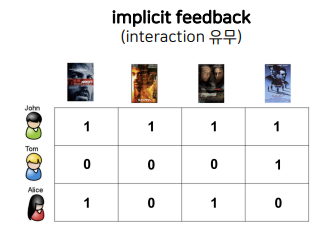

### 유저 기반

input = 행 - 사용자, 열 - 영화, 값 - 평점

output = 사용자를 기준으로 유사한 사용자를 기반으로 하여 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
id2title = {}
title2id =  {}

for title, movieId in zip(movie['original_title'], movie['movieId']):
  id2title[movieId] = title
  title2id[title] = movieId

In [ ]:
idx = title2id['Spider-Man 2']

In [ ]:
user_base = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
CF = cosine_similarity(user_base, user_base)

CF = pd.DataFrame(CF)

CF.index = user_base.index
CF.columns = user_base.index

CF.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.111740,0.045325,0.000000,0.086490,0.000000,0.032783,0.000000,0.000000,0.000000,0.000000,0.000000,0.071269,0.000000,0.034227,0.000000,0.037557,0.000000,0.038273,0.024563,0.000000,0.000000,0.031046,0.008707,0.000000,0.000000,0.000000,0.028411,0.000000,0.000000,0.026469,0.069263,0.221793,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.192117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101221,0.000000,0.052842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009864,0.019835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.172900,0.118982,0.105927,0.000000,0.231172,0.104280,0.116057,0.030537,0.052084,0.037455,0.172195,0.000000,0.171843,0.038412,0.071566,0.055953,0.268472,0.228920,0.202110,0.180975,0.168400,0.249213,0.000000,0.102100,0.111028,0.023069,0.000000,0.212831,0.060590,0.467765,0.008785,0.104402,0.056084,0.356193,0.035815,0.152837,0.247376,0.000000,...,0.189478,0.444176,0.018088,0.109337,0.030110,0.000000,0.000000,0.364601,0.054521,0.358967,0.011426,0.000000,0.078427,0.042366,0.108901,0.142976,0.082853,0.580094,0.077104,0.000000,0.092570,0.197608,0.288885,0.080703,0.017538,0.364068,0.268140,0.410457,0.028742,0.045788,0.472035,0.141222,0.095300,0.247965,0.474999,0.514490,0.093228,0.044339,0.173073,0.109078
3,0.000000,0.172900,1.000000,0.065062,0.138674,0.000000,0.186351,0.305685,0.251273,0.140265,0.203351,0.095581,0.273498,0.090567,0.168436,0.117627,0.230167,0.000000,0.141914,0.261753,0.113236,0.234655,0.201617,0.150036,0.056093,0.323469,0.269160,0.061812,0.214477,0.191809,0.383895,0.148821,0.056043,0.173783,0.056353,0.171260,0.095049,0.320959,0.152108,0.167290,...,0.457783,0.198638,0.138476,0.313322,0.061468,0.094487,0.095034,0.224273,0.000000,0.119542,0.000000,0.281006,0.087487,0.000000,0.080035,0.166211,0.183835,0.180996,0.000000,0.145250,0.046786,0.171063,0.220387,0.166498,0.058180,0.236644,0.293252,0.166036,0.048898,0.149950,0.192807,0.099797,0.261200,0.215030,0.202532,0.132969,0.234504,0.106074,0.224741,0.206307
4,0.111740,0.118982,0.065062,1.000000,0.150233,0.095480,0.257316,0.139444,0.037562,0.042169,0.047777,0.044334,0.136463,0.012966,0.271004,0.024864,0.145663,0.036218,0.250437,0.112031,0.254595,0.195233,0.157932,0.091644,0.060980,0.093488,0.054757,0.051197,0.000000,0.281944,0.114180,0.172571,0.112645,0.186496,0.065346,0.077123,0.063587,0.110368,0.071644,0.029541,...,0.057274,0.174381,0.113474,0.100559,0.065338,0.036522,0.027550,0.107418,0.082971,0.144993,0.028175,0.091907,0.010609,0.116768,0.289766,0.151996,0.089203,0.138479,0.006519,0.132561,0.108505,0.092659,0.347745,0.101594,0.088569,0.089438,0.095068,0.124158,0.047251,0.024087,0.098178,0.056254,0.131530,0.256273,0.119800,0.108244,0.102466,0.121362,0.009076,0.146577
5,0.045325,0.105927,0.138674,0.150233,1.000000,0.076042,0.134511,0.201534,0.094029,0.064509,0.026257,0.052451,0.157746,0.138843,0.220570,0.078957,0.072902,0.044494,0.146392,0.163455,0.115469,0.156297,0.236486,0.052275,0.076954,0.088175,0.096618,0.014537,0.000000,0.222909,0.060094,0.166250,0.070295,0.124624,0.000000,0.068823,0.091708,0.104348,0.084024,0.000000,...,0.078255,0.188976,0.056450,0.065264,0.043369,0.029629,0.000000,0.161292,0.127143,0.201646,0.000000,0.033891,0.065626,0.149358,0.229219,0.057205,0.215303,0.184311,0.033846,0.064525,0.066882,0.275139,0.333700,0.176331,0.154932,0.084650,0.129926,0.133325,0.036799,0.000000,0.228081,0.000000,0.140585,0.237052,0.155886,0.069493,0.000000,0.000000,0.073629,0.206709


In [ ]:
def getCF(userId):

  my_df = movie[movie['userId'] == userId]
  my_df = my_df['original_title'].values.tolist()

  recommend_ldx = CF.loc[userId, :].sort_values(ascending = False)[ :10].index.tolist()[1]

  recommend_df = movie[movie['userId'] == recommend_ldx]
  recommend_df = recommend_df['original_title'].values.tolist()

  print(f'=====My({userId}) Movie List=====')
  print(*my_df, sep='\n')
  print()
  print(f'=====Most similar User({recommend_ldx}) List=====')
  print(*recommend_df, sep='\n')

In [ ]:
getCF(1)

=====My(1) Movie List=====
Rocky III
Greed
American Pie
My Tutor
Jay and Silent Bob Strike Back
Vivement dimanche!

=====Most similar User(325) List=====
Rocky III
My Tutor
Monsters, Inc.
Tuya de hun shi
Underworld
The Great Dictator
28 Weeks Later
Back to the Future
Frankenstein Unbound


### 아이템 기반

input = 행 - 영화, 열 - 사용자, 값 - 평점

output = 영화를 기준으로 평점이 유사한 영화를 기반으로 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
id2title = {}
title2id =  {}

for title, movieId in zip(movie['original_title'], movie['movieId']):
  id2title[movieId] = title
  title2id[title] = movieId

In [ ]:
idx = title2id['Spider-Man 2']

In [ ]:
item_base = movie.pivot_table(index='movieId', columns = 'userId', values = 'rating').fillna(0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
CBF= cosine_similarity(item_base, item_base)

CBF = pd.DataFrame(CBF)

CBF.index = item_base.index
CBF.columns = item_base.index

CBF.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,1.0,0.0,0.0,0.0,0.0,0.086712,0.000000,0.099687,0.0,0.07711,0.0,0.043202,0.0,0.340909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.062243,0.0,0.000000,0.000000,0.000000,0.0,0.187916,0.12219,0.081759,0.0,0.0,0.0,0.0,0.0,0.0,0.100710,0.0,0.197315,0.0,...,0.047324,0.0,0.0,0.0,0.0,0.0,0.0,0.307729,0.082572,0.0,0.102418,0.0,0.0,0.000000,0.0,0.0,0.0,0.082572,0.0,0.000000,0.0,0.0,0.0,0.000000,0.08547,0.0,0.240296,0.0,0.094704,0.0,0.0,0.000000,0.0,0.0,0.143825,0.0,0.102418,0.133132,0.078507,0.0
100017,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.251602,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.624695,0.0,0.000000,0.0,0.0,0.578542,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
100032,0.0,0.0,1.0,0.0,0.0,0.245026,0.423207,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.029745,0.0,0.813733,0.229416,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.053359,0.0,0.106866,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.138782,0.0,0.0,0.0,0.124035,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.196649,0.000000,0.0
100272,0.0,0.0,0.0,1.0,0.0,0.245026,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.341743,0.0,0.118980,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.222051,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
100450,0.0,0.0,0.0,0.0,1.0,0.000000,0.282138,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.118980,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.184999,0.0,0.0,0.0,0.000000,0.0,0.222051,0.0,0.0,0.0,0.000000,0.00000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [ ]:
def getCBF(movieId):

  title = id2title[movieId]
  recommend_list = []
  recommend_ldx = CBF.loc[movieId, :].sort_values(ascending = False)[ :10].index.tolist()
  recommend_list = [id2title[idx] for idx in recommend_ldx]

  print(f'입력 영화: {title}')
  print()
  print(f'=====Most similar List=====')

  return recommend_list

In [ ]:
getCBF(idx)

입력 영화: Spider-Man 2

=====Most similar List=====


['Spider-Man 2',
 'The Great Global Warming Swindle',
 'As Good as It Gets',
 'Close Encounters of the Third Kind',
 'Pierrot le fou',
 'Trick',
 'The Holiday',
 'House of Frankenstein',
 'Pi',
 'Forrest Gump']

## Latent Factor Model

사용자가 매긴 평점을 바탕으로 잠재요인을 찾아서 ? 부분을 유추해내는 방식

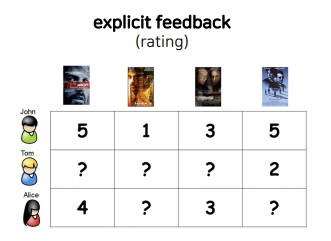

### SGD

가중치를 동시에 초기화

input = 행 - 사용자, 열 - 영화, 값 - 평점

output = 사용자가 보지 않은 영화의 평점을 추론하여 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = df.iloc[:, : ].values

In [ ]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

import numpy as np

# Base code : https://yamalab.tistory.com/92
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)

In [ ]:
factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=100, verbose=True)
factorizer.fit()

Iteration: 10 ; cost = 0.8341
Iteration: 20 ; cost = 0.8074
Iteration: 30 ; cost = 0.7916
Iteration: 40 ; cost = 0.7789
Iteration: 50 ; cost = 0.7681
Iteration: 60 ; cost = 0.7586
Iteration: 70 ; cost = 0.7502
Iteration: 80 ; cost = 0.7429
Iteration: 90 ; cost = 0.7363
Iteration: 100 ; cost = 0.7306


In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
factorizer.get_complete_matrix()

array([[2.39563166, 1.74930765, 1.24809117, ..., 2.80052208, 1.81612915,
        2.81013474],
       [3.5164389 , 2.85180345, 2.95014439, ..., 3.96138126, 3.14120525,
        3.81285786],
       [4.89052362, 4.81619837, 3.30627145, ..., 2.66607157, 1.89491717,
        2.75301727],
       ...,
       [3.70262147, 3.08783214, 2.95125486, ..., 3.94584142, 3.08214603,
        3.75289806],
       [3.55411346, 2.79249382, 3.34985997, ..., 4.87603876, 3.60187204,
        2.03721604],
       [3.14783051, 2.22571234, 3.06300267, ..., 4.87674571, 3.9101293 ,
        3.91327632]])

### ALS

가중치를 순서대로 초기화

input = 행 - 사용자, 열 - 영화, 값 - 평점

output = 사용자가 보지 않은 영화의 평점을 추론하여 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = df.iloc[:, : ].values

In [ ]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Base code : https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
class AlternatingLeastSquares():
    def __init__(self, R, k, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        # init latent features
        self._users = np.random.normal(size=(self._num_users, self._k))
        self._items = np.random.normal(size=(self._num_items, self._k))

        # train while epochs
        self._training_process = []
        self._user_error = 0; self._item_error = 0; 
        for epoch in range(self._epochs):
            for i, Ri in enumerate(self._R):
                self._users[i] = self.user_latent(i, Ri)
                self._user_error = self.cost()
                
            for j, Rj in enumerate(self._R.T):
                self._items[j] = self.item_latent(j, Rj)
                self._item_error = self.cost()
                
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """
        xi, yi = self._R.nonzero()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def user_latent(self, i, Ri):
        """
        :param error: rating - prediction error
        :param i: user index
        :param Ri: Rating of user index i
        :return: convergence value of user latent of i index
        """

        du = np.linalg.solve(np.dot(self._items.T, np.dot(np.diag(Ri), self._items)) + self._reg_param * np.eye(self._k),
                                   np.dot(self._items.T, np.dot(np.diag(Ri), self._R[i].T))).T
        return du

    def item_latent(self, j, Rj):
        """
        :param error: rating - prediction error
        :param j: item index
        :param Rj: Rating of item index j
        :return: convergence value of itemr latent of j index
        """

        di = np.linalg.solve(np.dot(self._users.T, np.dot(np.diag(Rj), self._users)) + self._reg_param * np.eye(self._k),
                                 np.dot(self._users.T, np.dot(np.diag(Rj), self._R[:, j])))
        return di


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._users[i, :].dot(self._items[j, :].T)


    def get_complete_matrix(self):
        """
        :return: complete matrix R^
        """
        return self._users.dot(self._items.T)

In [ ]:
# 속도가 매우느려 임의로 평점을 조정함
R = np.array([
    [1, 0, 0, 1, 3],
    [2, 0, 3, 1, 1],
    [1, 2, 0, 5, 0],
    [1, 0, 0, 4, 4],
    [2, 1, 5, 4, 0],
    [5, 1, 5, 4, 0],
    [0, 0, 0, 1, 0],
])

als = AlternatingLeastSquares(R = R, reg_param = 0.1, epochs=100, verbose=True, k=5)
als.fit()

Iteration: 10 ; cost = 0.0200
Iteration: 20 ; cost = 0.0166
Iteration: 30 ; cost = 0.0151
Iteration: 40 ; cost = 0.0145
Iteration: 50 ; cost = 0.0143
Iteration: 60 ; cost = 0.0143
Iteration: 70 ; cost = 0.0144
Iteration: 80 ; cost = 0.0146
Iteration: 90 ; cost = 0.0147
Iteration: 100 ; cost = 0.0148


In [ ]:
R

array([[1, 0, 0, 1, 3],
       [2, 0, 3, 1, 1],
       [1, 2, 0, 5, 0],
       [1, 0, 0, 4, 4],
       [2, 1, 5, 4, 0],
       [5, 1, 5, 4, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
als.get_complete_matrix()

array([[ 0.99053917,  0.3100578 ,  1.01097062,  1.027693  ,  2.97420339],
       [ 1.99260444, -0.05728324,  2.9807566 ,  1.02478082,  1.00020902],
       [ 1.00184226,  1.97387914,  2.38603688,  4.98765392,  2.59747164],
       [ 1.01181648,  1.51901049,  2.24122549,  3.99156938,  3.98754542],
       [ 2.01519626,  1.01238285,  4.98771579,  3.99528795,  2.42583374],
       [ 4.98642764,  1.00193712,  5.00113259,  3.99713092,  3.0848964 ],
       [ 0.21991405,  0.37845909,  0.52443128,  0.98187058,  0.51760309]])

# AutoEncoder-based Model

## AE

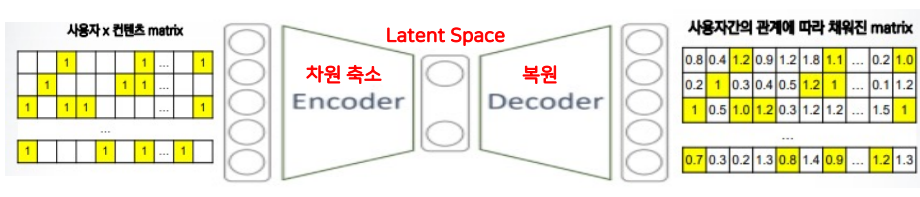

사용자가 매긴 평점을 바탕으로 인코딩과 디코딩을 통해서 ? 부분을 유추해내는 방식

input = 행 - 사용자, 열 - 영화, 값 - 평점

output = 사용자가 보지 않은 영화의 평점을 추론하여 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = df.iloc[:, : ].values

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# 학습 조건 설정
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.Tensor(self.x_data[idx])
      return x
    else:
      x = torch.Tensor(self.x_data[idx])
      y = torch.Tensor(self.y_data[idx])
      return x, y

In [ ]:
# AutoEncoder 모델 설계
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(2830, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32)
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 2830)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0

  for batch_idx, (feature) in enumerate(train_loader):

    feature = feature.to(DEVICE)
    target = feature.to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(feature)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
# 모델 정의
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=2830, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2830, bias=True)
  )
)


In [ ]:
train_dataset = CustomDataset(R)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 0.2913

[EPOCH: 2], 	Train Loss: 0.2677

[EPOCH: 3], 	Train Loss: 0.2581

[EPOCH: 4], 	Train Loss: 0.2472

[EPOCH: 5], 	Train Loss: 0.2355

[EPOCH: 6], 	Train Loss: 0.2306

[EPOCH: 7], 	Train Loss: 0.2277

[EPOCH: 8], 	Train Loss: 0.2299

[EPOCH: 9], 	Train Loss: 0.2281

[EPOCH: 10], 	Train Loss: 0.2292


In [ ]:
def evaluate(model, train_loader):
  model.eval()
  result = []

  with torch.no_grad():

    for feature in train_loader:
      feature = feature.to(DEVICE)
      _, decoded = model(feature)
      result.append(decoded.cpu().numpy())

  result = np.concatenate(result)

  return result

result = evaluate(model, train_loader)
result

array([[ 0.03414949, -0.00705559, -0.01245978, ...,  0.00981715,
        -0.0072503 , -0.00445226],
       [-0.17716849,  0.05056265,  0.02536668, ..., -0.08960695,
         0.08169347, -0.0778148 ],
       [-0.00573398,  0.00499678, -0.01650207, ...,  0.00198242,
        -0.01964105, -0.01075399],
       ...,
       [ 0.01516606, -0.01361931, -0.01914574, ...,  0.0276698 ,
        -0.0256141 , -0.00381552],
       [ 0.0179247 ,  0.00132252, -0.02694143, ...,  0.05192481,
        -0.01880549, -0.01678251],
       [ 0.00644503,  0.03192773, -0.0186066 , ...,  0.02419448,
        -0.04850829, -0.04290579]], dtype=float32)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## VAE

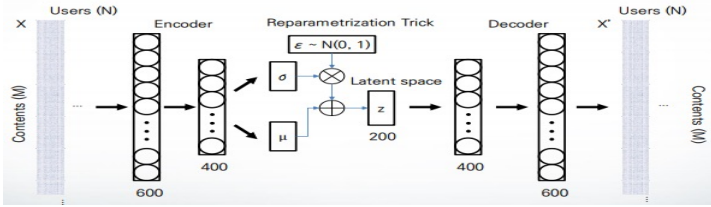

사용자의 영화 시청 여부를 바탕으로 인코딩과 디코딩을 통해서 ? 부분을 유추해내는 방식

input = 행 - 사용자, 열 - 영화, 값 - 시청 여부

output = 사용자가 보지 않은 영화에 대하여 추론하여 볼 확률이 높다면 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie['one'] = 1
movie.head()

,userId,movieId,rating,timestamp,original_title,one
0,1,1371,2.5,1260759135,Rocky III,1
1,4,1371,4.0,949810302,Rocky III,1
2,7,1371,3.0,851869160,Rocky III,1
3,19,1371,4.0,855193404,Rocky III,1
4,21,1371,3.0,853852263,Rocky III,1


In [ ]:
df = movie.pivot_table(index='userId', columns = 'original_title', values = 'one').fillna(0)
df.head()

original_title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...Più forte ragazzi!,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 + 1,12 Angry Men,13 Tzameti,1408,15 Minutes,16 Blocks,1724 기방난동사건,1942: A Love Story,1984,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,2046,2061 - Un anno eccezionale,21 Grams,24 Hour Party People,25th Hour,28 Days Later,28 Weeks Later,29th Street,2:37,3 Ninjas: High Noon at Mega Mountain,3 hommes et un couffin,300,33 sceny z życia,36 Fillette,"4 luni, 3 săptămîni și 2 zile",40 Days and 40 Nights,42nd Street,48 Hrs.,...,真夜中の弥次さん喜多さん,続宮本武蔵 一乗寺の決闘,綠草地,纵横四海,羅生門,英雄,菊次郎の夏,薔薇の葬列,蜘蛛巣城,裸の島,誰も知らない,豚と軍艦,赤ひげ,野火,鎗王之王,隠し砦の三悪人,風の谷のナウシカ,香港製造,鬼婆,鷹爪鐵布衫,거룩한 계보,고지전,공동경비구역 JSA,괴물,김복남 살인사건의 전말,다세포 소녀,도쿄!,밀양,봄 여름 가을 겨울 그리고 봄,빈집,사마리아,야수,연가시,오직 그대만,올드보이,"장화, 홍련",최종병기 활,친절한 금자씨,해안선,활
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
watching_metrix = df.iloc[:, : ].values

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# 학습 조건 설정
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.FloatTensor(self.y_data[idx])
      return x, y

In [ ]:
# AutoEncoder 모델 설계
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1_1 = nn.Linear(2798, 256)
        self.fc1_2 = nn.Linear(2798, 256)
        self.relu = nn.ReLU()
                        
    def encode(self, x):
        mu = self.relu(self.fc1_1(x))
        log_var = self.relu(self.fc1_2(x))
                
        return mu,log_var
    
    def reparametrize(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(DEVICE)
        
        return eps.mul(std).add_(mu)
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        reparam = self.reparametrize(mu,log_var)
        
        return mu,log_var,reparam
        
encoder = Encoder().to(DEVICE)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(256, 2798)
        self.simoid = nn.Sigmoid()
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.simoid(out)
        
        return out
        
decoder = Decoder().to(DEVICE)

In [ ]:
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, log_var):
    MSE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return MSE + KLD

parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0005)

In [ ]:
def train(encoder, decoder, train_loader):
  encoder.train()
  decoder.train()
  train_loss = 0

  for feature in train_loader:

    feature = feature.to(DEVICE)
    optimizer.zero_grad()
    mu,log_var,reparam = encoder(feature)
    output = decoder(reparam)
    loss = loss_function(output, feature, mu, log_var)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def evaluate(encoder, decoder, train_loader):
  encoder.eval()
  decoder.eval()
  result = []

  with torch.no_grad():

    for feature in train_loader:
      feature = feature.to(DEVICE)
      mu,log_var,reparam = encoder(feature)
      output = decoder(reparam)
      result.append(output.cpu().numpy())

  result = np.concatenate(result)
  return result

In [ ]:
train_dataset = CustomDataset(watching_metrix)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(encoder, decoder, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 4117.4286

[EPOCH: 2], 	Train Loss: 4116.1290

[EPOCH: 3], 	Train Loss: 4099.3126

[EPOCH: 4], 	Train Loss: 4130.7653

[EPOCH: 5], 	Train Loss: 4138.9610

[EPOCH: 6], 	Train Loss: 4132.8868

[EPOCH: 7], 	Train Loss: 4051.5376

[EPOCH: 8], 	Train Loss: 4167.4207

[EPOCH: 9], 	Train Loss: 4129.5442

[EPOCH: 10], 	Train Loss: 4106.9828

[EPOCH: 11], 	Train Loss: 4112.0285

[EPOCH: 12], 	Train Loss: 4050.0675

[EPOCH: 13], 	Train Loss: 4136.6195

[EPOCH: 14], 	Train Loss: 4068.3379

[EPOCH: 15], 	Train Loss: 4099.4888

[EPOCH: 16], 	Train Loss: 4068.8668

[EPOCH: 17], 	Train Loss: 4040.6214

[EPOCH: 18], 	Train Loss: 4053.3887

[EPOCH: 19], 	Train Loss: 4055.9068

[EPOCH: 20], 	Train Loss: 4086.3976

[EPOCH: 21], 	Train Loss: 4115.2169

[EPOCH: 22], 	Train Loss: 4078.7156

[EPOCH: 23], 	Train Loss: 4036.3207

[EPOCH: 24], 	Train Loss: 4060.8590

[EPOCH: 25], 	Train Loss: 4080.0301

[EPOCH: 26], 	Train Loss: 4016.3489

[EPOCH: 27], 	Train Loss: 4118.2530

[EPOCH: 2

In [ ]:
result = evaluate(encoder, decoder, train_loader)
result

array([[0.02168645, 0.0246637 , 0.02140205, ..., 0.02180524, 0.03178142,
        0.01445626],
       [0.00261145, 0.00110983, 0.0026538 , ..., 0.00086054, 0.00582997,
        0.00310753],
       [0.0096163 , 0.00513556, 0.00956157, ..., 0.00541279, 0.03060465,
        0.01281654],
       ...,
       [0.01006816, 0.0156631 , 0.01284728, ..., 0.00826485, 0.01942413,
        0.02451329],
       [0.00388942, 0.00166335, 0.00378707, ..., 0.00159731, 0.01076492,
        0.00411391],
       [0.00315707, 0.00200301, 0.00284829, ..., 0.00288775, 0.00853438,
        0.0067078 ]], dtype=float32)

In [ ]:
watching_metrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
movie_li = df.columns.tolist()
result[watching_metrix >= 1] = -1

In [ ]:
recommend_li = []
for i in result.argmax(axis=1):
  recommend_li.append(movie_li[i])

In [ ]:
recommend_df = pd.DataFrame()
recommend_df['user_id'] = df.index.tolist()
recommend_df['movie'] = recommend_li
recommend_df.head(10)

,user_id,movie
0,1,Rain Man
1,2,Rain Man
2,3,The 39 Steps
3,4,Men in Black II
4,5,The Million Dollar Hotel
5,6,Monsoon Wedding
6,7,Terminator 3: Rise of the Machines
7,8,Men in Black II
8,9,Terminator 3: Rise of the Machines
9,10,Terminator 3: Rise of the Machines


현재 user_id 7 에게 Terminator 3: Rise of the Machines 영화를 추천해주었다는 것을 알 수 있다. 

현재 추천시스템의 성능을 파악하기 위해서는 user_id 7이 Terminator관련 영화를 보았다는 가정이 필요하다.

In [ ]:
for i in df.columns.tolist():
  if 'Terminator' in i:
    print(i)

Terminator 2: Judgment Day
Terminator 3: Rise of the Machines
Terminator Salvation
The Terminator
The Terminators


현재 영화 리스트에 Terminator관련 영화가 5개가 존재한다는 것을 알 수 있다.

In [ ]:
for i in df.iloc[6][df.iloc[6] >= 1].index.tolist():
  if 'Terminator' in i:
    print(i)

Terminator Salvation


user_id 7은 Terminator Salvation 영화를 보았었기 때문에 Terminator 3: Rise of the Machines 영화를 추천해준 것은 어느 정도 타당성이 존재한다고 볼 수 있다.

하지만 현재 모델 자체의 성능이 우수하다고 평가할 수는 없을 것이다. 왜냐하면 user_id 7이 Terminator Salvation 영화에 대해서 어떠한 평가를 내렸을지에 대한 요소가 포함되지 않았으며 대부분의 사람들에게 Terminator 관련 영화를 추천해주는 것처럼 보이는데 단순히 많은 사람들이 보았기 때문에 추천을 해줄 수도 있기 때문이다. 그럼에도 현재 모델이 Terminator 관련 영화를 본 사람에게 Terminator 관련 영화를 추천해준 것에 큰 의의를 가진다. 

# MLP-based Model

## Softmax DNN

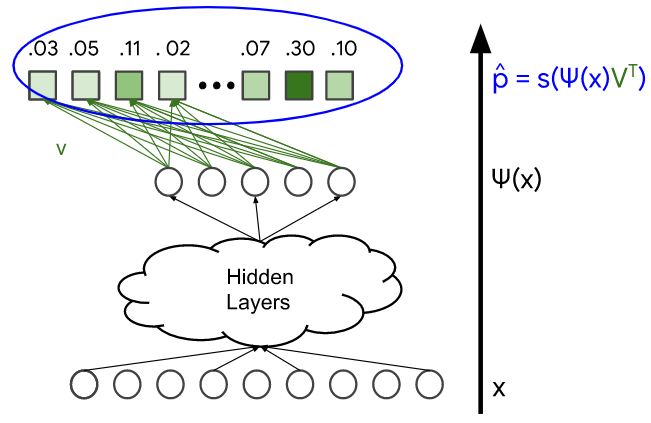

input = 행 - 영화, 열 - 영화에 대한 feature

output = 영화의 feature들을 기반으로 각 영화마다의 확률 값을 구한 임베딩을 통하여 사용자에게 유사한 영화를 추천

주의 - 만약 유저의 쿼리를 기반으로 feature를 만든다면 새로운 NN을 만들어 두 NN을 concat하여 사용해야함

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False).dropna(axis = 0)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
scaler.fit(meta['original_title'].values.reshape(-1,1))
meta['target'] = scaler.transform(meta['original_title'].values.reshape(-1,1)).reshape(-1,1)

In [ ]:
cols = ['revenue', 'runtime', 'vote_average', 'vote_count']
X = meta[cols]
y = meta['target']

In [ ]:
X.head()

,revenue,runtime,vote_average,vote_count
9,352194034.0,130.0,6.6,1194.0
68,28215918.0,91.0,7.0,513.0
69,25836616.0,108.0,6.9,1644.0
153,1275000.0,83.0,6.8,28.0
178,66000000.0,92.0,5.2,153.0


In [ ]:
y.head()

9      197
68     178
69     182
153     83
178    321
Name: target, dtype: int64

In [ ]:
X = X.values

In [ ]:
y = y.values

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
num_classes = meta['target'].nunique()

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = (x_data - x_data.min(axis = 0)) / (x_data.max(axis = 0) - x_data.min(axis = 0))
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.LongTensor(self.y_data.reshape(-1,1)[idx])[0]
      return x, y

In [ ]:
# 추천시스템의 DNN은 기존 DNN의 성능 향상을 위한 테크닉이 적용되지 않는 다는 것을 알 수 있으며 
# 추천시스템의 DNN은 기존의 신경망들과 다른 방식으로 구성하는 것이 더 좋아보임  

class MLP(nn.Module):
  def __init__(self, num_classes):
    super(MLP, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(4, 512),
        # nn.BatchNorm1d(512), # 제거하는 것이 더 높은 성능을 보임
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        # nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        # nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [ ]:
def weiht_init(model):
  if isinstance(model, nn.Linear):
    torch.nn.init.kaiming_uniform_(model.weight.data)

In [ ]:
model = MLP(num_classes).to(DEVICE)
model.apply(weiht_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

MLP(
  (linear1): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=688, bias=True)
  )
)


In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for X_train, y_train in train_loader:
    X_train = X_train.to(DEVICE)
    y_train = y_train.to(DEVICE)
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(y_train.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [ ]:
def evaluate(model, train_loader):
  model.eval()
  result = []
  correct = 0

  with torch.no_grad():
    for X_train, y_train in train_loader:
      X_train = X_train.to(DEVICE)
      y_train = y_train.to(DEVICE)
      output= model(X_train)
      result.append(F.softmax(output).cpu().numpy())

      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(y_train.view_as(prediction)).sum().item()

  train_accuracy = 100. * correct / len(train_loader.dataset)
  result = np.concatenate(result)

  return result, train_accuracy

In [ ]:
train_dataset = CustomDataset(X, y)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False,
  )

for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %")


[EPOCH: 1], 	Train Loss: 6.6707, 	Train Accuracy: 0.00 %

[EPOCH: 2], 	Train Loss: 6.5354, 	Train Accuracy: 0.00 %

[EPOCH: 3], 	Train Loss: 6.5174, 	Train Accuracy: 0.14 %

[EPOCH: 4], 	Train Loss: 6.5026, 	Train Accuracy: 0.29 %

[EPOCH: 5], 	Train Loss: 6.4792, 	Train Accuracy: 0.87 %

[EPOCH: 6], 	Train Loss: 6.4484, 	Train Accuracy: 0.72 %

[EPOCH: 7], 	Train Loss: 6.4115, 	Train Accuracy: 0.58 %

[EPOCH: 8], 	Train Loss: 6.3650, 	Train Accuracy: 0.72 %

[EPOCH: 9], 	Train Loss: 6.3127, 	Train Accuracy: 0.72 %

[EPOCH: 10], 	Train Loss: 6.2541, 	Train Accuracy: 1.01 %

[EPOCH: 11], 	Train Loss: 6.1936, 	Train Accuracy: 1.01 %

[EPOCH: 12], 	Train Loss: 6.1279, 	Train Accuracy: 1.30 %

[EPOCH: 13], 	Train Loss: 6.0566, 	Train Accuracy: 1.30 %

[EPOCH: 14], 	Train Loss: 5.9826, 	Train Accuracy: 1.44 %

[EPOCH: 15], 	Train Loss: 5.9046, 	Train Accuracy: 1.73 %

[EPOCH: 16], 	Train Loss: 5.8147, 	Train Accuracy: 2.16 %

[EPOCH: 17], 	Train Loss: 5.7242, 	Train Accuracy: 2.02 %

[EPOC

In [ ]:
result, accuracy = evaluate(model, train_loader)
result

array([[1.0767877e-18, 3.4300737e-19, 4.2245387e-26, ..., 2.1071240e-24,
        5.9889235e-36, 9.6821925e-22],
       [7.2728955e-17, 3.6710449e-07, 1.4407671e-14, ..., 3.8502356e-05,
        1.9274886e-07, 6.9426460e-04],
       [2.2937906e-25, 9.3925911e-14, 7.8212972e-21, ..., 1.5739254e-18,
        3.2095802e-16, 1.0838572e-10],
       ...,
       [7.6261451e-05, 1.9025101e-12, 3.1307419e-13, ..., 8.7437252e-11,
        1.9165679e-28, 2.4881820e-14],
       [8.5223544e-30, 2.0921386e-42, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9982689e-30, 4.5956610e-32, 4.2319214e-43, ..., 8.4180876e-25,
        9.4467810e-33, 2.2849368e-28]], dtype=float32)

In [ ]:
print(f"Accuracy: {accuracy:.2f} %")

Accuracy: 73.45 %


## GMF



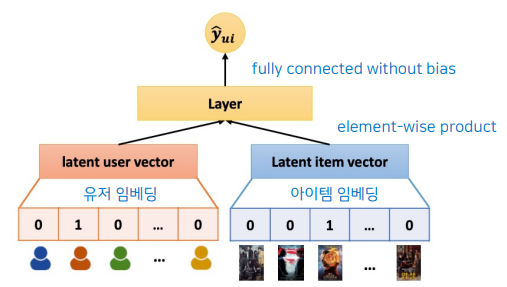

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

Latent user vector = (user_num ,factor)

Latent item vector = (item_num ,factor)

element_wise_product = Latent user vector * Latent item vector

out = FC_layer(element_wise_product, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features:
  labels.append(R[i, j])

In [ ]:
class GMF(nn.Module):
  def __init__(self, user_num, item_num, factor_num):
      super(GMF, self).__init__()

      # 유저 임베딩
      self.user_embedding = nn.Embedding(user_num, factor_num)

      # 아이템 임베딩
      self.item_embedding = nn.Embedding(item_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.user_embedding.weight, std=0.01)
      nn.init.normal_(self.item_embedding.weight, std=0.01)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      user_embedding = self.user_embedding(user)
      item_embedding = self.item_embedding(item)

      element_wise_product = (user_embedding * item_embedding)

      out = self.FC_layer(element_wise_product)
      out = out.view(-1, 1)

      return out

In [ ]:
model = GMF(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 5.3773

[EPOCH: 2], 	Train Loss: 1.2619

[EPOCH: 3], 	Train Loss: 1.1715

[EPOCH: 4], 	Train Loss: 1.0327

[EPOCH: 5], 	Train Loss: 1.0122

[EPOCH: 6], 	Train Loss: 1.0085

[EPOCH: 7], 	Train Loss: 1.0077

[EPOCH: 8], 	Train Loss: 1.0085

[EPOCH: 9], 	Train Loss: 1.0105

[EPOCH: 10], 	Train Loss: 1.0097


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[3.7138, 3.6987, 3.2571,  ..., 3.6739, 3.8039, 3.3279],
        [3.6944, 3.6226, 3.2220,  ..., 3.5323, 3.7053, 3.3520],
        [3.6992, 3.6691, 3.2339,  ..., 3.7036, 3.7126, 3.3699],
        ...,
        [3.4746, 3.4848, 3.2166,  ..., 3.5475, 3.4125, 3.2990],
        [3.5124, 3.9856, 3.1557,  ..., 3.7447, 3.9399, 3.3669],
        [3.8064, 3.9688, 3.2248,  ..., 3.8354, 4.0464, 3.3846]],
       device='cuda:0')

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(3.7009, device='cuda:0')

In [ ]:
R[0, 168]

2.5

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

## MLP-based MF

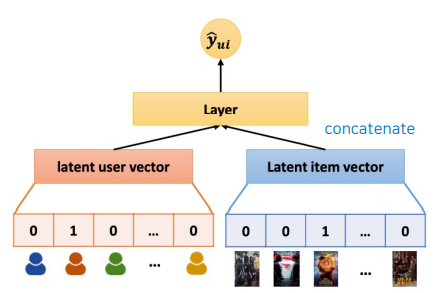

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

Latent user vector = (user_num ,factor)

Latent item vector = (item_num ,factor)

concat_two_latent_vactors = concat(Latent user vector, Latent item vector)

output_MLP = MLP_layer(concat_two_latent_vactors)

out = FC_layer(output_MLP, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features:
  labels.append(R[i, j])

In [ ]:
class MLP_MF(nn.Module):
  def __init__(self, user_num, item_num, factor_num, num_layers = 3):
      super(MLP_MF, self).__init__()

      # 유저 임베딩
      self.user_embedding = nn.Embedding(user_num, factor_num)

      # 아이템 임베딩
      self.item_embedding = nn.Embedding(item_num, factor_num)

      MLP_modules = []
      input_size = factor_num * 2
      for i in range(num_layers):
        MLP_modules.append(nn.Linear(input_size, input_size // 2))
        MLP_modules.append(nn.ReLU())
        input_size //=  2
      self.MLP_layers = nn.Sequential(*MLP_modules)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(input_size, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.xavier_uniform_(self.user_embedding.weight)
      nn.init.xavier_uniform_(self.item_embedding.weight)
      for m in self.MLP_layers:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      user_embedding = self.user_embedding(user)
      item_embedding = self.item_embedding(item)

      concat_two_latent_vactors = torch.cat((user_embedding, item_embedding), -1)
      output_MLP = self.MLP_layers(concat_two_latent_vactors)

      out = self.FC_layer(output_MLP)
      out = out.view(-1)

      return out

In [ ]:
model = MLP_MF(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 1.8819

[EPOCH: 2], 	Train Loss: 0.9376

[EPOCH: 3], 	Train Loss: 1.0602

[EPOCH: 4], 	Train Loss: 0.8491

[EPOCH: 5], 	Train Loss: 0.8045

[EPOCH: 6], 	Train Loss: 0.7997

[EPOCH: 7], 	Train Loss: 0.7977

[EPOCH: 8], 	Train Loss: 0.7798

[EPOCH: 9], 	Train Loss: 0.7641

[EPOCH: 10], 	Train Loss: 0.7298


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[3.1145, 2.1494, 2.2385,  ..., 3.7837, 2.7288, 2.3369],
        [3.1839, 3.1165, 3.1165,  ..., 3.8756, 3.4651, 3.4379],
        [3.1165, 3.1165, 3.1165,  ..., 3.7639, 3.3615, 3.2690],
        ...,
        [3.4907, 2.5599, 3.0067,  ..., 4.2342, 3.6537, 3.6173],
        [3.2756, 3.1165, 3.4353,  ..., 3.9577, 3.4664, 3.4700],
        [3.3810, 2.4370, 2.7961,  ..., 4.1518, 3.3872, 3.2096]])

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(2.1373)

In [ ]:
R[0, 168]

2.5

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

## NCF

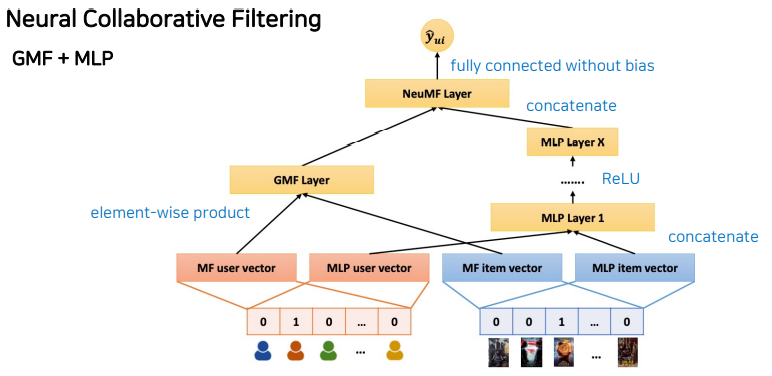

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

GMF Latent user vector = (user_num ,factor)

GMF Latent item vector = (item_num ,factor)

MLP Latent user vector = (user_num ,factor)

MLP Latent item vector = (item_num ,factor)

output_GMF = GMF Latent user vector * GMF Latent item vector

MLP_concat_two_latent_vactors = concat(MLP Latent user vector, MLP Latent item vector)

output_MLP = MLP_layer(MLP_concat_two_latent_vactors)

output = concat(output_GMF, output_MLP)

out = FC_layer(output, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features:
  labels.append(R[i, j])

In [ ]:
class GMF_and_MLP(nn.Module):
  def __init__(self, user_num, item_num, factor_num, num_layers = 3):
      super(GMF_and_MLP, self).__init__()

      # GMF 임베딩
      self.GMF_user_embedding = nn.Embedding(user_num, factor_num)
      self.GMF_item_embedding = nn.Embedding(item_num, factor_num)

      # MLP 임베딩
      self.MLP_user_embedding = nn.Embedding(user_num, factor_num)
      self.MLP_item_embedding = nn.Embedding(item_num, factor_num)

      MLP_modules = []
      input_size = factor_num * 2
      for i in range(num_layers):
        MLP_modules.append(nn.Linear(input_size, input_size // 2))
        MLP_modules.append(nn.ReLU())
        input_size //=  2
      self.MLP_layers = nn.Sequential(*MLP_modules)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num + input_size, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.GMF_user_embedding.weight, std=0.01)
      nn.init.normal_(self.GMF_item_embedding.weight, std=0.01)
      nn.init.normal_(self.MLP_user_embedding.weight, std=0.01)
      nn.init.normal_(self.MLP_item_embedding.weight, std=0.01)

      for m in self.MLP_layers:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      GMF_user_embedding = self.GMF_user_embedding(user)
      GMF_item_embedding = self.GMF_item_embedding(item)

      output_GMF = (GMF_user_embedding * GMF_item_embedding)

      MLP_user_embedding = self.MLP_user_embedding(user)
      MLP_item_embedding = self.MLP_item_embedding(item)

      concat_two_latent_vactors = torch.cat((MLP_user_embedding, MLP_item_embedding), -1)
      output_MLP = self.MLP_layers(concat_two_latent_vactors)

      concat_GMF_MLP = torch.cat((output_GMF, output_MLP), -1)

      out = self.FC_layer(concat_GMF_MLP)
      out = out.view(-1)

      return out

In [ ]:
model = GMF_and_MLP(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 1.4863

[EPOCH: 2], 	Train Loss: 0.8686

[EPOCH: 3], 	Train Loss: 0.8743

[EPOCH: 4], 	Train Loss: 0.6191

[EPOCH: 5], 	Train Loss: 0.4452

[EPOCH: 6], 	Train Loss: 0.3894

[EPOCH: 7], 	Train Loss: 0.3588

[EPOCH: 8], 	Train Loss: 0.3374

[EPOCH: 9], 	Train Loss: 0.3164

[EPOCH: 10], 	Train Loss: 0.3157


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[3.3646, 2.9302, 3.2288,  ..., 3.2210, 1.9280, 2.6346],
        [4.0337, 2.3965, 3.0552,  ..., 3.1314, 2.8062, 3.7697],
        [3.6591, 2.5289, 2.9345,  ..., 4.2492, 3.9218, 3.8126],
        ...,
        [1.7532, 2.7788, 3.7487,  ..., 4.1492, 3.3240, 2.7195],
        [3.2449, 3.0934, 3.4631,  ..., 4.0583, 3.6396, 3.5495],
        [3.5456, 2.5031, 3.6707,  ..., 3.5429, 3.6101, 3.9073]])

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(1.6956)

In [ ]:
R[0, 168]

2.5

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

# 참고자료

- https://developers.google.com/machine-learning/recommendation?hl=ko

- https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=194

- https://www.youtube.com/watch?v=1fhNX_JFaow

- https://brunch.co.kr/@kakao-it/72#comment

- https://www.youtube.com/watch?v=h6vePourB7E&list=LL&index=1&t=15s

- https://ratsgo.github.io/generative%20model/2018/01/27/VAE/

- https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/08_Autoencoder/3_Variational_Autoencoder.ipynb

- https://ko-kr.facebook.com/groups/TensorFlowKR/permalink/524873987853664/

- https://doheelab.github.io/recommender-system/ncf_mlp/